#Mount and imports

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [2]:
!nvidia-smi

Wed Nov  3 13:44:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install transformers==4.2.1
!pip install farasapy
!pip install pyarabic
!pip install sentencepiece
!git clone https://github.com/aub-mind/arabert
!git clone https://github.com/iR00i/JUST-Arabic-Propaganda.git

     |████████████████████████████████| 1.8 MB 7.7 MB/s 
     |████████████████████████████████| 895 kB 55.9 MB/s 
     |████████████████████████████████| 2.9 MB 58.4 MB/s 
     |████████████████████████████████| 126 kB 8.6 MB/s 
     |████████████████████████████████| 1.2 MB 8.1 MB/s 
Cloning into 'arabert'...
remote: Enumerating objects: 556, done.
remote: Counting objects: 100% (342/342), done.
remote: Compressing objects: 100% (245/245), done.
remote: Total 556 (delta 182), reused 244 (delta 91), pack-reused 214
Receiving objects: 100% (556/556), 9.16 MiB | 2.05 MiB/s, done.
Resolving deltas: 100% (305/305), done.
Cloning into 'JUST-Arabic-Propaganda'...
remote: Enumerating objects: 1533, done.
remote: Counting objects: 100% (1533/1533), done.
remote: Compressing objects: 100% (1423/1423), done.
remote: Total 1533 (delta 49), reused 1518 (delta 37), pack-reused 0
Receiving objects: 100% (1533/1533), 3.02 MiB | 18.54 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [4]:
import pandas as pd
import numpy as np
import re

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from arabert.preprocess import ArabertPreprocessor
import transformers
from sklearn import model_selection
from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from sklearn.metrics import confusion_matrix
%matplotlib inline

#Utility

In [7]:
def eval_fn(data_loader, model, device):
  """
  Similar to the training function but the model is in evaluation mode (model 
  layers are frozen).

  Performs forward-prop on the model with the validation data.
  Returns the model predictions as well as the data gold labels.
  """
  fin_targets = []
  fin_outputs = []
  with torch.no_grad():
    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
      ids = d["ids"]
      token_type_ids = d["token_type_ids"]
      mask = d["mask"]
      targets = d["targets"]

      ids = ids.to(device, dtype=torch.long)
      token_type_ids = token_type_ids.to(device, dtype=torch.long)
      mask = mask.to(device, dtype=torch.long)
      targets = targets.to(device, dtype=torch.float)

      outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
      fin_targets.extend(targets.cpu().detach().numpy().tolist())
      fin_outputs.extend(F.softmax(outputs, dim = 1).cpu().detach().numpy().tolist())
  return fin_outputs, fin_targets

In [8]:
def MapLabels(df):
  """
  Function to preprocess data.
  Creates a one-hot-encoded version of the labels.
  """
  onehot_col = []
  map = {
      'Appeal_to_Authority':0,
      'Appeal_to_fear-prejudice':1,
      'Bandwagon,Reductio_ad_hitlerum':2,
      'Black-and-White_Fallacy':3,
      'Causal_Oversimplification':4,
      'Doubt':5,
      'Exaggeration,Minimisation':6,
      'Flag-Waving':7,
      'Loaded_Language':8,
      'Name_Calling,Labeling':9,
      'Repetition':10,
      'Slogans':11,
      'Thought-terminating_Cliches':12,
      'Whataboutism,Straw_Men,Red_Herring':13
  }

  for idx,row in df.iterrows():
    temp = [0] * 14
    label = row['label']
    temp[map[label]] = 1
    onehot_col.append(temp)
  
  df['onehot'] = onehot_col
  return df

In [90]:
class Dataset:
  """
  Class Dataset used to create an iterable version of the dataset with the
  ability to return the text tokenized upon indexing.

  An object of this class can be treated as a list object. Indexing with this 
  object (ex: dataset[idx] ) will return a dictionary. 
  """
  def __init__(self, text, target):
    self.text = text
    self.target = target
    self.max_len = config['MAX_LEN']

  def __len__(self):
    return len(self.text)
  
  def getitem(self, item, tokenizer):
    text = str(self.text[item])
    text = " ".join(text.split())

    inputs = tokenizer.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        padding='max_length',
        truncation='longest_first'
    )

    ids = inputs['input_ids']
    mask = inputs['attention_mask']
    token_type_ids = inputs['token_type_ids']

    return {
        "ids": torch.tensor(ids, dtype=torch.long),
        "mask": torch.tensor(mask, dtype=torch.long),
        "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
        "targets": torch.tensor(self.target[item], dtype=torch.float),
    }

In [ ]:
def predict(model, ids, token_type_ids, mask):
  outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
  prediction = F.softmax(outputs, dim = 1).cpu().detach().numpy()
  prediction = np.squeeze(prediction, axis = 0)
  prediction = (prediction >=0.5).astype(int).tolist()
  return prediction

In [ ]:
def Ensemble(models, test, weights=[1]*len(models)):
  test = MapLabels(test)
  test_dataset = Dataset(
        text=test['Arabic'].values,
        target=test['onehot'].values,
    )
  predictions = []
  targets = test['onehot'].values.tolist()
  print("Using models:\n")
  for model in models:
    print(model.model_id)
  for i in tqdm(range(len(test))):

    ensemble_predictions = []
    for model in models:
      data = test_dataset.getitem(i, model.tokenizer)
      ids = data['ids'].unsqueeze(dim=0).to(device)
      token_type_ids = data['token_type_ids'].unsqueeze(dim=0).to(device)
      mask = data['mask'].unsqueeze(dim=0).to(device)
      prediction = predict(model,
                          ids=ids,
                          token_type_ids=token_type_ids,
                          mask=mask)
      ensemble_predictions.append(prediction)
    avg = np.average(np.array(ensemble_predictions), axis=0, weights=weights)
    avg = (avg >=0.5).astype(int).tolist()
    predictions.append(avg)

  f1_micro = metrics.f1_score(targets, predictions,average='micro')
  accuracy = metrics.accuracy_score(targets, predictions)
  print(f"<---------------Test Set Performance--------------->")
  print(f"f1-Micro Score = {f1_micro}")
  print(f"Accuracy Score = {accuracy}")

  return predictions, targets

In [149]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
  """
  Function to print confusion matrix for labels.
  """
  df_cm = pd.DataFrame(
      confusion_matrix, index=class_names, columns=class_names,
  )

  try:
      heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
  except ValueError:
      raise ValueError("Confusion matrix values must be integers.")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
  axes.set_ylabel('True label')
  axes.set_xlabel('Predicted label')
  axes.set_title(class_label)

#Architectures

In [192]:
class TransformerModel(nn.Module):
    def __init__(self, model_id, hidden_size, num_labels, tokenizer):
        super(TransformerModel, self).__init__()
        self.model_id = model_id
        self.tokenizer = tokenizer

        self.bert = transformers.BertModel.from_pretrained(model_id, return_dict=False)
        self.bert_drop = nn.Dropout(0.0)
        self.out = nn.Linear(hidden_size, num_labels)


    def forward(self, ids, mask, token_type_ids):
        _, o2 = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        bo = self.bert_drop(o2)
        output = self.out(bo)
        return output


#config

In [161]:
"""
aubmindlab/bert-base-arabertv02
asafaya/bert-base-arabic
kuisailab/albert-base-arabic
UBC-NLP/ARBERT
UBC-NLP/MARBERT
"""
config = {
    'MAX_LEN':200,
    'DEVICE':'cuda',
    'results_save_path':"/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Ensembles/",
}
device = torch.device(config['DEVICE'])

In [186]:
path = r'/content/JUST-Arabic-Propaganda/data/Translated Data/'
train = pd.read_csv(path+'train.csv')
valid = pd.read_csv(path+'valid.csv')
test = pd.read_csv(path+'test.csv')

#Load models

In [196]:
model_args = {
    'model_id':'asafaya/bert-base-arabic',
    'hidden_size':768,
    'num_labels':14,

    'model_path':"/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Transformers/model.bin",
}
tokenizer_1 = transformers.BertTokenizer.from_pretrained(model_args['model_id'])
model_1 = TransformerModel(model_id = model_args['model_id'],
                           hidden_size = model_args['hidden_size'],
                           num_labels = model_args['num_labels'],
                           tokenizer=tokenizer_1,
                           )

model_1.load_state_dict(torch.load(model_args['model_path']))


model_1.eval()
model_1.to(device)
something = 1

In [197]:
model_args = {
    'model_id':'UBC-NLP/ARBERT',
    'hidden_size':768,
    'num_labels':14,

    'model_path':"/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Tuning/UBC-NLP-ARBERT_final_model.bin",
}
tokenizer_2 = transformers.BertTokenizer.from_pretrained(model_args['model_id'])
model_2 = TransformerModel(model_id = model_args['model_id'],
                           hidden_size = model_args['hidden_size'],
                           num_labels = model_args['num_labels'],
                           tokenizer=tokenizer_2,
                           )

model_2.load_state_dict(torch.load(model_args['model_path']))


model_2.eval()
model_2.to(device)
something = 1

In [198]:
model_args = {
    'model_id':'aubmindlab/bert-base-arabertv02',
    'hidden_size':768,
    'num_labels':14,

    'model_path':"/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Tuning/bert-base-arabertv02_final_model.bin",
}
tokenizer_3 = transformers.BertTokenizer.from_pretrained(model_args['model_id'])
model_3 = TransformerModel(model_id = model_args['model_id'],
                           hidden_size = model_args['hidden_size'],
                           num_labels = model_args['num_labels'],
                           tokenizer=tokenizer_3,
                           )

model_3.load_state_dict(torch.load(model_args['model_path']))


model_3.eval()
model_3.to(device)
something = 1

#Run

In [202]:
models = [model_1, model_2, model_3]
predictions, targets = Ensemble(models, test)

Using models:

asafaya/bert-base-arabic
UBC-NLP/ARBERT
aubmindlab/bert-base-arabertv02


  0%|          | 0/720 [00:00<?, ?it/s]

<---------------Test Set Performance--------------->
f1-Micro Score = 0.6652014652014652
Accuracy Score = 0.6305555555555555



                                    precision    recall  f1-score   support

               Appeal_to_Authority     0.5625    0.5625    0.5625        16
          Appeal_to_fear-prejudice     0.4815    0.3824    0.4262        34
    Bandwagon,Reductio_ad_hitlerum     0.5000    0.1429    0.2222         7
           Black-and-White_Fallacy     0.5000    0.2308    0.3158        13
         Causal_Oversimplification     0.5294    0.3913    0.4500        23
                             Doubt     0.6809    0.5714    0.6214        56
         Exaggeration,Minimisation     0.5897    0.4259    0.4946        54
                       Flag-Waving     0.8182    0.5625    0.6667        32
                   Loaded_Language     0.7800    0.7959    0.7879       245
             Name_Calling,Labeling     0.6935    0.6935    0.6935       124
                        Repetition     0.7424    0.6364    0.6853        77
                           Slogans     0.7857    0.6471    0.7097        17
       Tho

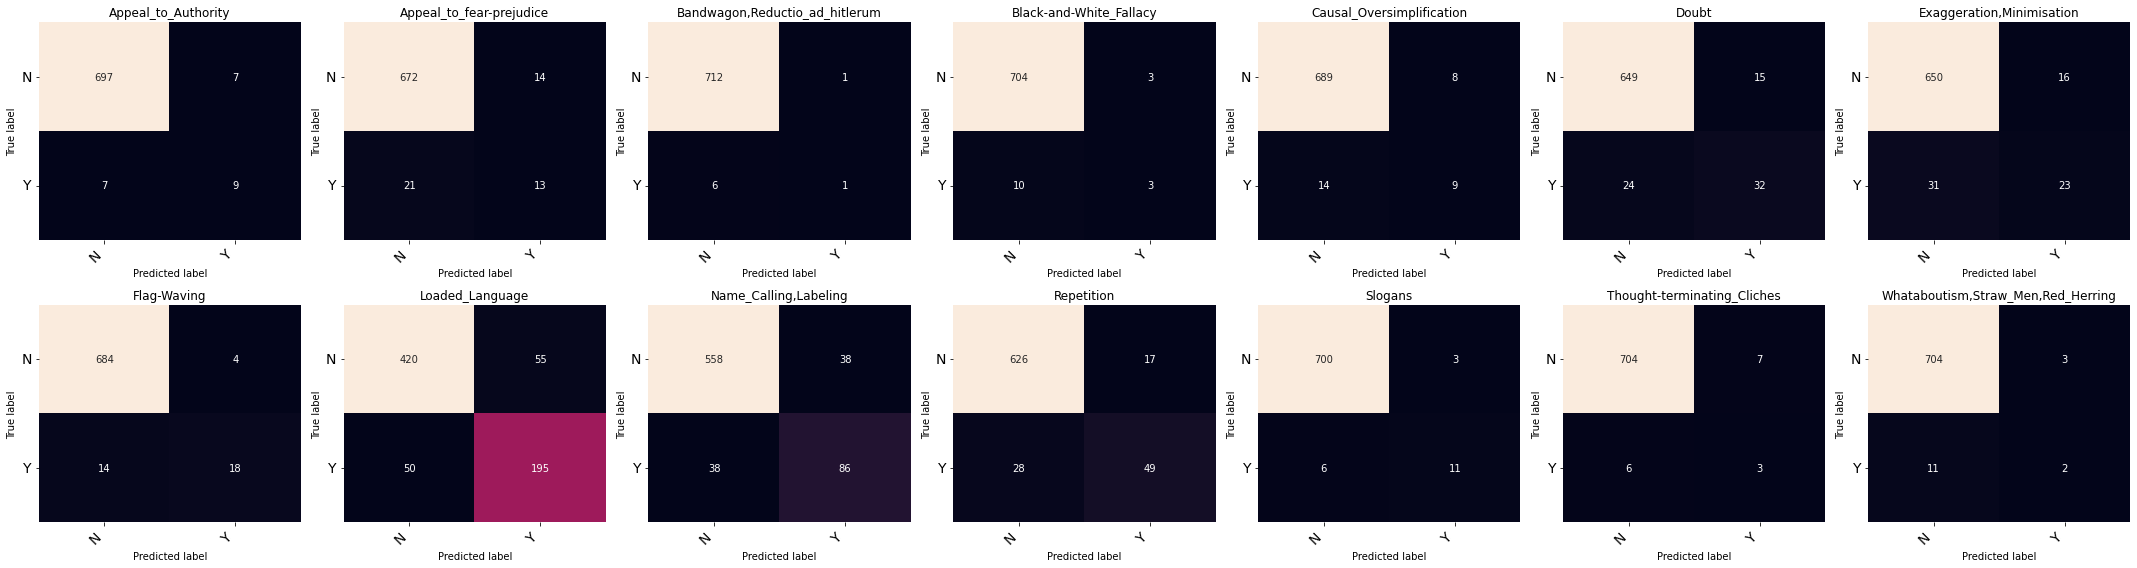

In [203]:
gold_list = targets
preds_list = predictions

target_names = [
      'Appeal_to_Authority',
      'Appeal_to_fear-prejudice',
      'Bandwagon,Reductio_ad_hitlerum',
      'Black-and-White_Fallacy',
      'Causal_Oversimplification',
      'Doubt',
      'Exaggeration,Minimisation',
      'Flag-Waving',
      'Loaded_Language',
      'Name_Calling,Labeling',
      'Repetition',
      'Slogans',
      'Thought-terminating_Cliches',
      'Whataboutism,Straw_Men,Red_Herring']


report = metrics.classification_report(gold_list, preds_list, target_names=target_names,zero_division=0,digits=4)
cm = metrics.multilabel_confusion_matrix(gold_list, preds_list)
accuracy = metrics.accuracy_score(gold_list, preds_list)

print()
print(report)

fig, ax = plt.subplots(2, 7, figsize=(30, 8))
for axes, cmi, label in zip(ax.flatten(), cm, target_names):
    print_confusion_matrix(cmi, axes, label, ["N", "Y"])
fig.tight_layout()
plt.show()
fig.savefig(config['results_save_path']+"confusion_matrices.png")